In [20]:
import numpy as np
import os
import pylab as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors

from datetime import datetime
import time

In [23]:
hist_start = 2008
hist_end = 2014
proj_start = hist_end + 1
proj_end = 2100

Plotting helpers

In [28]:
fontsize = 8
lw = 0.65
aspect_ratio = 0.35
markersize = 2

params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


secpera = 3.15569259747e7

grace_signal_lw = 0.75
mouginot_signal_lw = 0.75
imbie_signal_lw = 0.75
simulated_signal_lw = 0.3
grace_signal_color = "#084594"
grace_sigma_color = "#9ecae1"
mouginot_signal_color = "#a63603"
mouginot_sigma_color = "#fdbe85"
imbie_signal_color = "#005a32"
imbie_sigma_color = "#a1d99b"
mankoff_signal_color = "#54278f"
mankoff_sigma_color = "#bcbddc"
simulated_signal_color = "0.7"

gt2cmSLE = 1.0 / 362.5 / 10.0

rcp_list = ["26", "45", "85"]
rcp_col_dict = {"CTRL": "k", 85: "#990002", 45: "#5492CD", 26: "#003466"}


## Load ISMIP Greenland projections

In [261]:
ismip6 = pd.read_csv("ismip6_gris_ctrl_removed.csv.gz")

## Prepare GRACE time series

In [268]:
grace = pd.read_csv(
    "grace/greenland_mass_200204_202008.txt",
    header=30,
    delim_whitespace=True,
    skipinitialspace=True,
    names=["Year", "Cumulative ice sheet mass change (Gt)", "Cumulative ice sheet mass change uncertainty (Gt)"],
    )
# Normalize GRACE signal to the starting date of the projection
grace["Cumulative ice sheet mass change (Gt)"] -= np.interp(
    proj_start, grace["Year"], grace["Cumulative ice sheet mass change (Gt)"]
)

# Get the GRACE trend
grace_time = (grace["Year"] >= hist_start) & (grace["Year"] <= proj_start)
grace_hist_df = grace[grace_time]
x = grace_hist_df["Year"]
y = grace_hist_df["Cumulative ice sheet mass change (Gt)"]   
s = grace_hist_df["Cumulative ice sheet mass change uncertainty (Gt)"]
X = sm.add_constant(x)
ols = sm.OLS(y, X).fit()
p = ols.params
grace_bias = p[0]
grace_trend = p[1]
grace_trend_stderr = ols.bse[1]


## Prepare Aschwanden et al (2019) projections

In [272]:
as19_norm = pd.read_csv("as19/aschwanden_et_al_2019_les_2015_norm.csv.gz")
as19_norm["SLE (cm)"] = -as19_norm["Mass (Gt)"] / 362.5 / 10
as19_norm = as19_norm.astype({"RCP": int, "Experiment": int})

In [388]:
def plot_prognostic(ismip6, as19):
    """
    Plot model projections
    """

    xmin = -5
    xmax = 45
    
    fig, ax = plt.subplots(
        1,
        2,
        sharey="col",
        figsize=[6.2, 3.0],
        num="prognostic_all",
        clear=True,
        gridspec_kw=dict(width_ratios=[10, 1]),
    )
    fig.subplots_adjust(wspace=0.05)

    def plot_signal(g, *kwargs):

        return ax[0].plot(g[-1]["Year"], g[-1]["SLE (cm)"], zorder=-10, color="#8c510a", linewidth=0.5, alpha=0.1, *kwargs)

    # Plot each model response by grouping
    [plot_signal(g) for g in ismip6.groupby(by=["Group", "Model", "Exp", "RCP"])]

    sns.kdeplot(
        data=ismip6[ismip6["Year"] == 2100],
        y="SLE (cm)",
        common_grid=True,
        common_norm=True,
        color="#8c510a",
        linewidth=0.75,
        ax=ax[1],
    )

    l_ismip6 = mlines.Line2D([], [], color="#8c510a", linewidth=1.0, linestyle="solid", label="ISMIP6")
    l_as19 = mlines.Line2D([], [], color="#01665e", linewidth=1.0, linestyle="solid", label="AS19")
    
    legend_1 = ax[0].legend(handles=[l_ismip6], loc="upper left")
    legend_1.get_frame().set_linewidth(0.0)
    legend_1.get_frame().set_alpha(0.0)

    sns.despine(ax=ax[1], left=True, bottom=True)
    try:
        ax[1].get_legend().remove()
    except:
        pass
    ax[0].set_ylim(xmin, xmax)
    ax[1].set_ylim(xmin, xmax)
    ax[0].set_xlim(proj_start, proj_end)
    ax[1].set_xlabel(None)
    ax[1].set_ylabel(None)
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    ax[0].set_xlabel("Year")
    ax[0].set_ylabel("SLE contribution (cm)")
    fig.savefig("GIS_ismip6_projection.pdf", bbox_inches="tight")
    
    g16 = ismip6.groupby(by=["Year"]).quantile(0.16).reset_index()
    g50 = ismip6.groupby(by=["Year"]).quantile(0.5).reset_index()
    g84 = ismip6.groupby(by=["Year"]).quantile(0.84).reset_index()
    # Percentiles at 2100
    p16 = g16[g16["Year"] == 2100]["SLE (cm)"].values[-1]
    p50 = g50[g50["Year"] == 2100]["SLE (cm)"].values[-1]
    p84 = g84[g84["Year"] == 2100]["SLE (cm)"].values[-1]
    
    ax[0].fill_between(g50["Year"], g16["SLE (cm)"], g84["SLE (cm)"], color="#bf812d", linewidth=1.0, alpha=1.0,)
    ax[0].plot(g16["Year"], g16["SLE (cm)"], color="#8c510a", linewidth=0.25, alpha=1.0,)
    ax[0].plot(g50["Year"], g50["SLE (cm)"], color="#8c510a", linewidth=1.0, alpha=1.0,)
    ax[0].plot(g84["Year"], g84["SLE (cm)"], color="#8c510a", linewidth=0.25, alpha=1.0,)
    
    ax[1].axhline(p16, color="#8c510a", linewidth=0.5, alpha=1.0,)
    ax[1].axhline(p50, color="#8c510a", linewidth=1.0, alpha=1.0,)
    ax[1].axhline(p84, color="#8c510a", linewidth=0.5, alpha=1.0,)
    ax[1].annotate(np.round(p16, 0), (0.13, p16), color="#8c510a", xycoords="data")
    ax[1].annotate(np.round(p50, 0), (0.13, p50), color="#8c510a", xycoords="data")
    ax[1].annotate(np.round(p84, 0), (0.13, p84), color="#8c510a", xycoords="data")

    fig.savefig("GIS_ismip6_projection_stats.pdf", bbox_inches="tight", pad_inches=0.1)


    def plot_signal(g, *kwargs):

        return ax[0].plot(g[-1]["Year"], g[-1]["SLE (cm)"], zorder=-9, color="#01665e", linewidth=0.5, alpha=0.1, *kwargs)

    # Plot each model response by grouping
    [plot_signal(g) for g in as19.groupby(by=["Experiment", "RCP"])]
    g16 = as19.groupby(by=["Year"]).quantile(0.16).reset_index()
    g50 = as19.groupby(by=["Year"]).quantile(0.5).reset_index()
    g84 = as19.groupby(by=["Year"]).quantile(0.84).reset_index()
    # Percentiles at 2100
    p16 = g16[g16["Year"] == 2100]["SLE (cm)"].values[-1]
    p50 = g50[g50["Year"] == 2100]["SLE (cm)"].values[-1]
    p84 = g84[g84["Year"] == 2100]["SLE (cm)"].values[-1]

    
    ax[0].fill_between(g50["Year"], g16["SLE (cm)"], g84["SLE (cm)"], color="#35978f", linewidth=1.0, alpha=1.0,)
    ax[0].plot(g16["Year"], g16["SLE (cm)"], color="#01665e", linewidth=0.25, alpha=1.0,)
    ax[0].plot(g50["Year"], g50["SLE (cm)"], color="#01665e", linewidth=1.0, alpha=1.0,)
    ax[0].plot(g84["Year"], g84["SLE (cm)"], color="#01665e", linewidth=0.25, alpha=1.0,)

    ax[1].axhline(p16, color="#01665e", linewidth=0.5, alpha=1.0,)
    ax[1].axhline(p50, color="#01665e", linewidth=1.0, alpha=1.0,)
    ax[1].axhline(p84, color="#01665e", linewidth=0.5, alpha=1.0,)

    ax[1].annotate(np.round(p16, 0), (0.13, p16), color="#01665e", xycoords="data")
    ax[1].annotate(np.round(p50, 0), (0.13, p50), color="#01665e", xycoords="data")
    ax[1].annotate(np.round(p84, 0), (0.13, p84), color="#01665e", xycoords="data")
    
    sns.kdeplot(
        data=as19[as19["Year"] == 2100],
        y="SLE (cm)",
        common_grid=True,
        common_norm=True,
        color="#01665e",
        linewidth=0.75,
        ax=ax[1],
    )

    legend_1 = ax[0].legend(handles=[l_ismip6, l_as19], loc="upper left")
    legend_1.get_frame().set_linewidth(0.0)
    legend_1.get_frame().set_alpha(0.0)

    fig.savefig("GIS_ismip6_as19_projection.pdf", bbox_inches="tight")




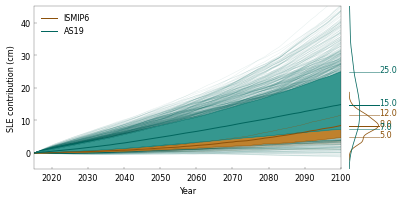

In [389]:
plot_prognostic(ismip6, as19_norm)

In [333]:
!open GIS_ismip6_*

In [328]:
plt.savefig?

In [352]:
sns.kdeplot?